# Student Assessments: Graph Analysis

## Dataset Description: Student Assessment Questionnaires

The dataset `assessment_generated.csv` contains information derived from student assessment questionnaires.

Each record represents an individual student's response and includes demographic, academic, and self-assessment information. The dataset comprises the following attributes:

- **`timestamp`**  
  The date and time when the assessment was submitted, formatted as `yyyy-mm-dd hh:mm:ss timezone`.

- **`netid`**  
  The encoded NetID of the student. Valid NetIDs must have a string length between 8 and 14 characters (inclusive). Entries falling outside this range are considered invalid.

- **`ruid`**  
  The encoded RUID of the student. A valid RUID is expected to contain exactly 18 characters. Any deviation from this length is considered invalid.

- **`section`**  
  The course section number as reported by the student. This field may contain inaccuracies, as some students provided incorrect section information.

- **`role`**  
  The academic standing of the student. Possible values include:
  - `Freshman`
  - `Sophomore`
  - `Junior`
  - `Senior`
  - `Graduate`
  - `Other`

- **`major`**  
  The declared major of the student. Accepted categories are:
  - `Computer Science`
  - `Electrical and Computer Engineering`
  - `Mathematics`
  - `Other`

- **Skill Proficiency Columns**  
  The following columns record students’ self-assessed proficiency levels in specific skills, rated on scales ranging from 0 up to a multiple of 5 (depending on the number of questions per topic). Missing values are present in some entries.

  - `data_structures`  
  - `calculus_and_linear_algebra`  
  - `probability_and_statistics`  
  - `data_visualization`  
  - `python_libraries`  
  - `shell_scripting`  
  - `sql`  
  - `python_scripting`  
  - `jupyter_notebook`  
  - `regression`  
  - `programming_languages`  
  - `algorithms`  
  - `complexity_measures`  
  - `visualization_tools`  
  - `massive_data_processing`


## Tasks

### Part I: Data Wrangling

*Note: This section follows a similar procedure to the previous bonus assignment.*

1.  **Handle Missing Values**
    *   Impute missing values in each skill proficiency column with the mean of that column.

2.  **Remove Duplicate Records**
    *   Eliminate duplicate entries, retaining only the record with the most recent `timestamp`.

3.  **Normalize Skill Proficiency**
    *   Apply both *z-score normalization* and *0-1 scaling* to each skill proficiency column. Retain both normalized versions for subsequent analysis.

4.  **Calculate Total Score**
    *   Generate a `total_score` column by summing the *z-score normalized* values across all skill proficiency topics for each student.

---

### Part II: Generating Graphs from Student Assessment Data

1.  **Data Inspection**
    *   Visualize the distribution of each skill proficiency topic using histograms for both 0-1 scaled scores and z-scores.

2.  **Define Distance Metric**
    *   Employ the *Euclidean distance* to quantify the similarity between students based on their normalized skill proficiency vectors.
      For students $A$ and $B$ with skill vectors $S_A$ and $S_B$:
      $$
      d(A, B) = \sqrt{\sum_{i=1}^{n} (S_{A,i} - S_{B,i})^2}
      $$
    *   Plot the distribution of all pairwise distances in a histogram.
    *   Apply *z-score normalization* to the computed pairwise distances.

3.  **Graph Construction Based on Distance Thresholds**
    *   Establish one or more thresholds at specified standard deviations (e.g., 3, 2, and 1) *below the mean distance*.
    *   For each threshold, construct an *undirected graph*. An edge is created between students $A$ and $B$ if their distance $d(A, B)$ is below the given threshold.
    *   Assign a name to each graph corresponding to the standard deviation used for its construction (e.g., `Student_Assessment_Graph_-3SD`, `Student_Assessment_Graph_-2SD`, `Student_Assessment_Graph_-1SD`).
        *   What can be inferred about the graph connectivity as the threshold varies? Specifically, compare the number of edges in `Student_Assessment_Graph_-3SD`, `Student_Assessment_Graph_-2SD`, and `Student_Assessment_Graph_-1SD`.

4.  **Graph Analysis**
    *   For each constructed graph, compute and report the following metrics:
        *   Number of nodes and edges.
        *   Average degree.
        *   Degree distribution, visualized as a scatter plot with a vertical line indicating the average degree.
        *   Identify the top 10% of students by degree. List their `netid`s and `total_score`s.
            *   Highlight the data points for these top 10% of students on the scatter plot.
              *(Reference: [Matplotlib Annotations](https://matplotlib.org/stable/tutorials/text/annotations.html))*.
        *   Number of connected components.
        *   Plot the edge and vertex size distributions of connected components as scatter plots, with vertical lines indicating the average sizes.
    *   **Visualization**
        *   Render each graph using a *force-directed layout* (e.g., `spring_layout` in NetworkX).
          *(Reference: [NetworkX Spring Layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html))*.
        *   Color the nodes in the visualizations based on their `total_score` using a suitable colormap.
          *(Reference: [Matplotlib Colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html))*.
        *   Save each graph in JSON format and create interactive visualizations using:
            *   [2D Force Graph](https://github.com/vasturiano/force-graph)
            *   [3D Force Graph](https://github.com/vasturiano/3d-force-graph)

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import json
from itertools import chain, combinations

# Define skill columns
skill_columns = [
    'data_structures', 'calculus_and_linear_algebra', 'probability_and_statistics',
    'data_visualization', 'python_libraries', 'shell_scripting', 'sql',
    'python_scripting', 'jupyter_notebook', 'regression', 'programming_languages',
    'algorithms', 'complexity_measures', 'visualization_tools', 'massive_data_processing'
]

In [62]:
if __name__ == "__main__":
    # Load the dataset
    df = pd.read_csv('assessment_generated.csv')
    display(df.head())
    df.info()

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting,sql,python_scripting,jupyter_notebook,regression,programming_languages,algorithms,complexity_measures,visualization_tools,massive_data_processing
0,2025-09-04 01:21:03 +0300,d2dbd3d0d5,786a2021217c6e2022,1,Junior,Computer Science,28.0,20.0,41.0,28.0,...,5.0,5.0,0.0,5.0,12.0,22.0,20.0,4.0,14.0,9.0
1,2025-09-04 00:28:39 +0200,c7dd9ac7c494,60703e393965793e3d,1,Junior,Computer Science,7.0,11.0,15.0,11.0,...,0.0,5.0,1.0,NaN,0.0,15.0,9.0,4.0,1.0,2.0
2,2025-09-03 18:22:47 -0400,5d504543461b,0f1d55565609195250,1,Senior,Mathematics,22.0,15.0,22.0,22.0,...,NaN,5.0,0.0,0.0,4.0,15.0,NaN,NaN,9.0,1.0
3,2025-09-04 06:29:53 +0800,021b4e0503,5145080b0b52450c0a,3,Senior,Computer Science,29.0,19.0,55.0,28.0,...,1.0,5.0,5.0,1.0,NaN,27.0,32.0,10.0,NaN,8.0
4,2025-09-03 16:31:34 -0600,8b8cc28089de,5d4c0104045b490005,1,Junior,Computer Science,25.0,14.0,43.0,23.0,...,1.0,5.0,1.0,1.0,12.0,13.0,7.0,0.0,6.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   timestamp                    157 non-null    object 
 1   netid                        157 non-null    object 
 2   ruid                         157 non-null    object 
 3   section                      157 non-null    int64  
 4   role                         157 non-null    object 
 5   major                        157 non-null    object 
 6   data_structures              148 non-null    float64
 7   calculus_and_linear_algebra  151 non-null    float64
 8   probability_and_statistics   152 non-null    float64
 9   data_visualization           151 non-null    float64
 10  python_libraries             147 non-null    float64
 11  shell_scripting              154 non-null    float64
 12  sql                          152 non-null    float64
 13  python_scripting    

# Part I: Data Wrangling

### 1. Handle Missing Values

In [63]:
def handle_missing_values(df, columns):
    """
    Fills missing values in specified columns with their respective column means.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    columns: list of str, the columns to fill.
    
    OUT:
    df: pd.DataFrame, the dataframe with missing values filled.
    """
    df_filled = df.copy()
    for col in columns:
        mean_value = df_filled[col].mean()
        df_filled[col].fillna(mean_value, inplace=True)
    return df_filled

In [64]:
if __name__ == "__main__":
    df_filled = handle_missing_values(df.copy(), skill_columns)
    display(df_filled.head())

/var/folders/88/kpzyxpcx36d10x1br1gjq1_80000gn/T/ipykernel_56510/3733683122.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filled[col].fillna(mean_value, inplace=True)


,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting,sql,python_scripting,jupyter_notebook,regression,programming_languages,algorithms,complexity_measures,visualization_tools,massive_data_processing
0,2025-09-04 01:21:03 +0300,d2dbd3d0d5,786a2021217c6e2022,1,Junior,Computer Science,28.0,20.0,41.0,28.0,...,5.00000,5.0,0.0,5.000000,12.000000,22.0,20.000000,4.00000,14.00000,9.0
1,2025-09-04 00:28:39 +0200,c7dd9ac7c494,60703e393965793e3d,1,Junior,Computer Science,7.0,11.0,15.0,11.0,...,0.00000,5.0,1.0,2.369128,0.000000,15.0,9.000000,4.00000,1.00000,2.0
2,2025-09-03 18:22:47 -0400,5d504543461b,0f1d55565609195250,1,Senior,Mathematics,22.0,15.0,22.0,22.0,...,1.11039,5.0,0.0,0.000000,4.000000,15.0,12.879195,3.75817,9.00000,1.0
3,2025-09-04 06:29:53 +0800,021b4e0503,5145080b0b52450c0a,3,Senior,Computer Science,29.0,19.0,55.0,28.0,...,1.00000,5.0,5.0,1.000000,4.061644,27.0,32.000000,10.00000,3.90411,8.0
4,2025-09-03 16:31:34 -0600,8b8cc28089de,5d4c0104045b490005,1,Junior,Computer Science,25.0,14.0,43.0,23.0,...,1.00000,5.0,1.0,1.000000,12.000000,13.0,7.000000,0.00000,6.00000,0.0


### 2. Remove Duplicate Records

Drop duplicates based on `ruid`, retaining the record with the latest `timestamp`.

In [65]:
def remove_duplicates(df):
    """
    Removes duplicate entries based on 'ruid', keeping the one with the latest 'timestamp'.

    IN:
    df: pd.DataFrame, the input dataframe.
    
    OUT:
    df: pd.DataFrame, the dataframe with duplicates removed.
    """
    # Your_Code_Here
    df_dedup = df.sort_values('timestamp').drop_duplicates(subset='ruid', keep='last')
    return df_dedup

In [66]:
if __name__ == "__main__":
    df_dedup = remove_duplicates(df_filled.copy())
    display(df_dedup.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting,sql,python_scripting,jupyter_notebook,regression,programming_languages,algorithms,complexity_measures,visualization_tools,massive_data_processing
98,2025-09-03 10:25:04 -1200,373e6a3439,8692d6dfdf8c90dade,3,Senior,Computer Science,21.0,15.0,39.0,21.000000,...,0.0,1.0,1.0,1.0,3.0,19.0,12.879195,0.0,0.0,0.000000
44,2025-09-03 11:27:47 -1100,c5c99ed8de,60723b393964783139,4,Senior,Computer Science,16.0,11.0,26.0,21.748344,...,1.0,1.0,1.0,5.0,3.0,11.0,7.000000,5.0,3.0,0.000000
107,2025-09-03 12:31:07 -1000,040e550b0c,2534797c7c23317c7a,3,Senior,Computer Science,26.0,10.0,35.0,27.000000,...,1.0,5.0,5.0,5.0,3.0,20.0,12.000000,6.0,8.0,1.463576
39,2025-09-03 12:35:07 -1000,706e27737827,e1f0bfb8b8e6f9bcbb,2,Senior,Computer Science,17.0,11.0,22.0,26.000000,...,5.0,5.0,0.0,5.0,3.0,14.0,13.000000,4.0,2.0,1.000000
10,2025-09-03 12:39:05 -1000,54490a53500a,fceeaca5a5fbeea3ac,3,Senior,Computer Science,35.0,15.0,44.0,35.000000,...,5.0,5.0,5.0,5.0,15.0,22.0,26.000000,10.0,14.0,6.000000


### 3. Normalize Skill Proficiency

The new columns for z-score normalization and 0-1 scaling should be named as follows:
- For a skill proficiency column named `skill_topic`, the z-score normalized column should be `skill_topic_zscore`.
- For a skill proficiency column named `skill_topic`, the 0-1 scaled column should be `skill_topic_01scale`.

In [67]:
def normalize_skills(df, columns):
    """
    Applies z-score normalization and 0-1 scaling to specified columns.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    columns: list of str, the columns to normalize.
    
    OUT:
    df: pd.DataFrame, the dataframe with added normalized columns.
    """
    # Your_Code_Here
    df_normalized = df.copy()
    zscore_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()
    for col in columns:
        z_col = f"{col}_zscore"
        df_normalized[z_col] = zscore_scaler.fit_transform(df_normalized[[col]])
        minmax_col = f"{col}_0_1"
        df_normalized[minmax_col] = minmax_scaler.fit_transform(df_normalized[[col]])
    return df_normalized

In [68]:
if __name__ == "__main__":
    df_normalized = normalize_skills(df_dedup.copy(), skill_columns)
    display(df_normalized.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,programming_languages_zscore,programming_languages_0_1,algorithms_zscore,algorithms_0_1,complexity_measures_zscore,complexity_measures_0_1,visualization_tools_zscore,visualization_tools_0_1,massive_data_processing_zscore,massive_data_processing_0_1
98,2025-09-03 10:25:04 -1200,373e6a3439,8692d6dfdf8c90dade,3,Senior,Computer Science,21.0,15.0,39.0,21.000000,...,0.627765,0.678571,-0.054641,0.367977,-1.232763,0.0,-0.785297,0.000000,-0.631725,0.000000
44,2025-09-03 11:27:47 -1100,c5c99ed8de,60723b393964783139,4,Senior,Computer Science,16.0,11.0,26.0,21.748344,...,-0.791922,0.392857,-0.833573,0.200000,0.363607,0.5,-0.194314,0.130435,-0.631725,0.000000
107,2025-09-03 12:31:07 -1000,040e550b0c,2534797c7c23317c7a,3,Senior,Computer Science,26.0,10.0,35.0,27.000000,...,0.805226,0.714286,-0.171125,0.342857,0.682881,0.6,0.790658,0.347826,-0.024142,0.121965
39,2025-09-03 12:35:07 -1000,706e27737827,e1f0bfb8b8e6f9bcbb,2,Senior,Computer Science,17.0,11.0,22.0,26.000000,...,-0.259539,0.500000,-0.038636,0.371429,0.044333,0.4,-0.391308,0.086957,-0.216589,0.083333
10,2025-09-03 12:39:05 -1000,54490a53500a,fceeaca5a5fbeea3ac,3,Senior,Computer Science,35.0,15.0,44.0,35.000000,...,1.160147,0.785714,1.683729,0.742857,1.959978,1.0,1.972624,0.608696,1.859089,0.500000


### 4. Calculate Total Score

In [69]:
def compute_total_score(df, zscore_columns):
    """
    Computes the total score as the sum of z-score normalized skill columns.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    zscore_columns: list of str, the z-score normalized columns to sum.
    
    OUT:
    df: pd.DataFrame, the dataframe with the 'total_score' column.
    """
    # Your_Code_Here
    df_total = df.copy()
    df_total['total_score'] = df_total[zscore_columns].sum(axis=1)
    return df_total

In [70]:
if __name__ == "__main__":
    zscore_cols = [f'{c}_zscore' for c in skill_columns]
    final_df = compute_total_score(df_normalized, zscore_cols)
    display(final_df.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,programming_languages_0_1,algorithms_zscore,algorithms_0_1,complexity_measures_zscore,complexity_measures_0_1,visualization_tools_zscore,visualization_tools_0_1,massive_data_processing_zscore,massive_data_processing_0_1,total_score
98,2025-09-03 10:25:04 -1200,373e6a3439,8692d6dfdf8c90dade,3,Senior,Computer Science,21.0,15.0,39.0,21.000000,...,0.678571,-0.054641,0.367977,-1.232763,0.0,-0.785297,0.000000,-0.631725,0.000000,-3.841991
44,2025-09-03 11:27:47 -1100,c5c99ed8de,60723b393964783139,4,Senior,Computer Science,16.0,11.0,26.0,21.748344,...,0.392857,-0.833573,0.200000,0.363607,0.5,-0.194314,0.130435,-0.631725,0.000000,-4.636315
107,2025-09-03 12:31:07 -1000,040e550b0c,2534797c7c23317c7a,3,Senior,Computer Science,26.0,10.0,35.0,27.000000,...,0.714286,-0.171125,0.342857,0.682881,0.6,0.790658,0.347826,-0.024142,0.121965,6.457406
39,2025-09-03 12:35:07 -1000,706e27737827,e1f0bfb8b8e6f9bcbb,2,Senior,Computer Science,17.0,11.0,22.0,26.000000,...,0.500000,-0.038636,0.371429,0.044333,0.4,-0.391308,0.086957,-0.216589,0.083333,2.518962
10,2025-09-03 12:39:05 -1000,54490a53500a,fceeaca5a5fbeea3ac,3,Senior,Computer Science,35.0,15.0,44.0,35.000000,...,0.785714,1.683729,0.742857,1.959978,1.0,1.972624,0.608696,1.859089,0.500000,24.503629


# Part II: Generating Graphs from Student Assessment Data

### 1. Data Inspection

Note: Use the population standard deviation (`ddof=0`) for all standard deviation calculations.

In [71]:
def compute_mean_std(df, zscore_cols, scale01_cols):
    """
    Computes and prints the mean and standard deviation for z-score normalized
    and 0-1 scaled skill columns.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    zscore_cols: list of str, the z-score normalized columns.
    scale01_cols: list of str, the 0-1 scaled columns.

    OUT:
    mean_std: dict of dicts {column_name: {'mean': mean_value, 'std': std_value}}, where mean_value and std_value are np.float64 types.
    """
    # Your_Code_Here
    mean_std = {}
    for col in zscore_cols + scale01_cols:
        if col not in df.columns:
            print(f"⚠️ Skipping missing column: {col}")
            continue
        mean_std[col] = {
            "mean": df[col].mean(),
            "std": df[col].std()
        }
    return mean_std

To indicate the mean and standard deviation on the histograms, you may use the following functions:
- `plt.axvline()` to draw vertical lines at the mean.
- `plt.annotate()` to label these lines with their corresponding values.

**References:**
- [`plt.axvline()` Documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)
- [`plt.annotate()` Documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html)

**Example Usage:**
```python
# Plot a vertical line at x=0
plt.axvline(x=0, color='r', linestyle='--')

# Annotate the line with text
plt.annotate('Mean', xy=(0, 0), color='red')
```

In [72]:
def plot_skill_distributions(df, zscore_cols, scale01_cols, mean_std):
    """
    Plots histograms for z-score and 0-1 scaled skill proficiency columns.
    Adds vertical lines and labels for mean values.
    
    IN:
    df: pd.DataFrame, the dataframe containing the data.
    zscore_cols: list of str, the z-score normalized columns.
    scale01_cols: list of str, the 0-1 scaled columns.
    mean_std: dict of dicts, mean and std dev for each column.
    """
    plt.figure(figsize=(14, 6))
    for i, col in enumerate(zscore_cols, 1):
        if col not in df.columns:
            print(f"⚠️ Skipping missing column: {col}")
            continue

        plt.subplot(1, len(zscore_cols), i)
        plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
        
        # Mean and std values
        mean = mean_std[col]['mean']
        std = mean_std[col]['std']
        
        # Title and labels
        plt.title(f"Z-score: {col}\nμ={mean:.2f}, σ={std:.2f}")
        plt.xlabel("Z-score")
        plt.ylabel("Frequency")

        # Add vertical line for mean
        plt.axvline(x=mean, color='red', linestyle='--', linewidth=1.5)
        plt.annotate(f"Mean = {mean:.2f}", xy=(mean, plt.ylim()[1]*0.9),
                     xytext=(mean + 0.1, plt.ylim()[1]*0.9),
                     color='red', fontsize=9)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(14, 6))
    for i, col in enumerate(scale01_cols, 1):
        if col not in df.columns:
            print(f"⚠️ Skipping missing column: {col}")
            continue

        plt.subplot(1, len(scale01_cols), i)
        plt.hist(df[col], bins=20, color='lightgreen', edgecolor='black')
        
        mean = mean_std[col]['mean']
        std = mean_std[col]['std']
        
        plt.title(f"0–1 Scaled: {col}\nμ={mean:.2f}, σ={std:.2f}")
        plt.xlabel("Scaled value")
        plt.ylabel("Frequency")
        plt.xlim(0, 1)

        # Add vertical mean line
        plt.axvline(x=mean, color='orange', linestyle='--', linewidth=1.5)
        plt.annotate(f"Mean = {mean:.2f}", xy=(mean, plt.ylim()[1]*0.9),
                     xytext=(mean + 0.02, plt.ylim()[1]*0.9),
                     color='orange', fontsize=9)
    plt.tight_layout()
    plt.show()

⚠️ Skipping missing column: data_structures_01scale
⚠️ Skipping missing column: calculus_and_linear_algebra_01scale
⚠️ Skipping missing column: probability_and_statistics_01scale
⚠️ Skipping missing column: data_visualization_01scale
⚠️ Skipping missing column: python_libraries_01scale
⚠️ Skipping missing column: shell_scripting_01scale
⚠️ Skipping missing column: sql_01scale
⚠️ Skipping missing column: python_scripting_01scale
⚠️ Skipping missing column: jupyter_notebook_01scale
⚠️ Skipping missing column: regression_01scale
⚠️ Skipping missing column: programming_languages_01scale
⚠️ Skipping missing column: algorithms_01scale
⚠️ Skipping missing column: complexity_measures_01scale
⚠️ Skipping missing column: visualization_tools_01scale
⚠️ Skipping missing column: massive_data_processing_01scale
data_structures_zscore: Mean = 0.0000, Std Dev = 1.0033
calculus_and_linear_algebra_zscore: Mean = -0.0000, Std Dev = 1.0033
probability_and_statistics_zscore: Mean = 0.0000, Std Dev = 1.0033

/var/folders/88/kpzyxpcx36d10x1br1gjq1_80000gn/T/ipykernel_56510/2624579769.py:35: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


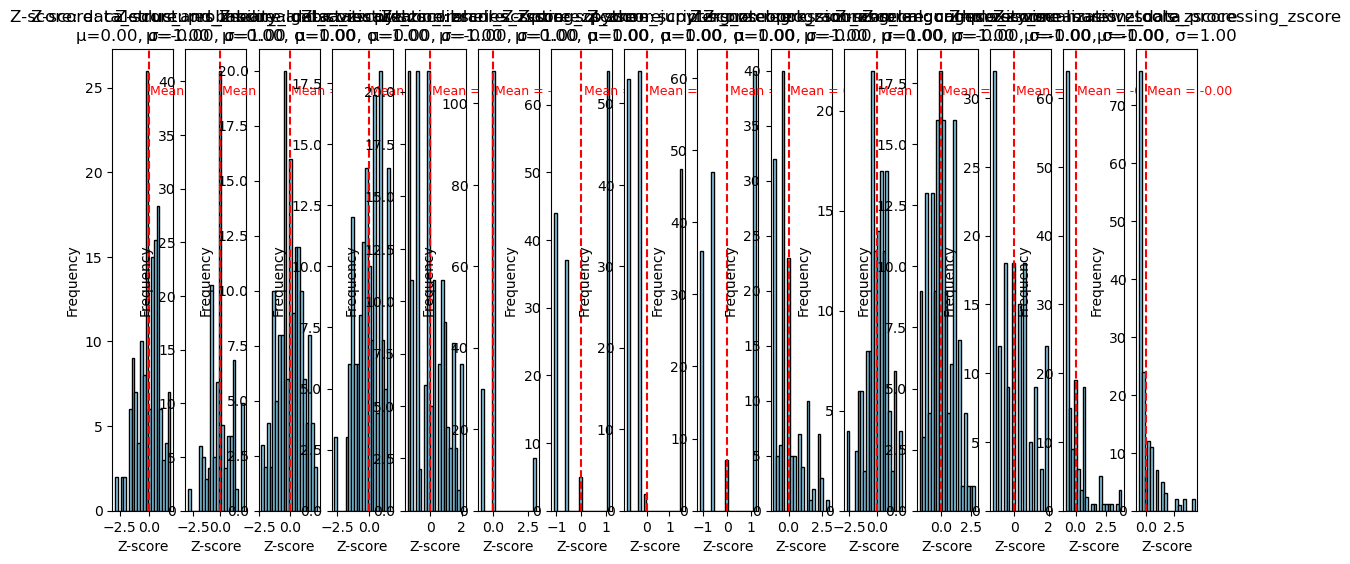

⚠️ Skipping missing column: data_structures_01scale
⚠️ Skipping missing column: calculus_and_linear_algebra_01scale
⚠️ Skipping missing column: probability_and_statistics_01scale
⚠️ Skipping missing column: data_visualization_01scale
⚠️ Skipping missing column: python_libraries_01scale
⚠️ Skipping missing column: shell_scripting_01scale
⚠️ Skipping missing column: sql_01scale
⚠️ Skipping missing column: python_scripting_01scale
⚠️ Skipping missing column: jupyter_notebook_01scale
⚠️ Skipping missing column: regression_01scale
⚠️ Skipping missing column: programming_languages_01scale
⚠️ Skipping missing column: algorithms_01scale
⚠️ Skipping missing column: complexity_measures_01scale
⚠️ Skipping missing column: visualization_tools_01scale
⚠️ Skipping missing column: massive_data_processing_01scale


<Figure size 1400x600 with 0 Axes>

In [73]:
if __name__ == "__main__":
    zscore_cols = [f'{c}_zscore' for c in skill_columns]
    scale01_cols = [f'{c}_01scale' for c in skill_columns]
    mean_std = compute_mean_std(final_df, zscore_cols, scale01_cols)
    for col, stats in mean_std.items():
        print(f"{col}: Mean = {stats['mean']:.4f}, Std Dev = {stats['std']:.4f}")
    plot_skill_distributions(final_df, zscore_cols, scale01_cols, mean_std)

### 2. Define Distance Metric

Note: The returned distance matrix is expected to have a shape of `(len(df), len(df))`, where each entry `(i, j)` corresponds to the distance between `df.iloc[i]` and `df.iloc[j]`. Consequently, the diagonal entries `(i, i)` must be zero.

In [74]:
def calculate_distances(df, zscore_cols):
    """
    Calculates pairwise Euclidean distances using only allowed imports.

    IN:
    df: pd.DataFrame, the dataframe with student data.
    zscore_cols: list of str, columns to use for distance calculation.

    OUT:
    distances: np.ndarray of shape (len(df), len(df)), pairwise distances.
    """
    # Extract z-score columns as NumPy array
    data = df[zscore_cols].to_numpy()

    # Use pdist to compute condensed pairwise distances (1D)
    condensed = pdist(data, metric='euclidean')

    # Convert condensed form to square distance matrix
    distances = squareform(condensed)

    return distances

Note: The condensed distance matrix is a flattened array that contains the upper triangular portion of the distance matrix, excluding the diagonal. Specifically, the first `len(df) - 1` entries represent the distances between the first data point and all subsequent points; the next `len(df) - 2` entries represent the distances between the second data point and all subsequent points, and so on.

**References:**
- [`scipy.spatial.distance.pdist` Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)
- [`scipy.spatial.distance.squareform` Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html)

In [75]:
def condense_distance_matrix(distances):
    """
    Condenses a square distance matrix into a condensed form.
    
    IN:
    distances: np.ndarray of shape (n, n), pairwise distances.
    
    OUT:
    condensed_distances: np.ndarray of shape (n*(n-1)/2,), condensed pairwise distances.
    """
    # Use SciPy's squareform to convert the square distance matrix
    condensed_distances = squareform(distances, checks=False)
    return condensed_distances

In [76]:
def squareform_distance_matrix(condensed_distances):
    """
    Converts a condensed distance matrix back to square form.
    
    IN:
    condensed_distances: np.ndarray of shape (n*(n-1)/2,), condensed pairwise distances.
    
    OUT:
    distances: np.ndarray of shape (n, n), pairwise distances.
    """
    # Convert condensed distance vector back to full square matrix
    distances = squareform(condensed_distances)
    return distances

In [77]:
def normalize_distances(condensed_distances):
    """
    Applies z-score normalization to distances.
    
    IN:
    condensed_distances: np.ndarray of shape (n*(n-1)/2,), condensed pairwise distances.

    OUT:
    condensed_distances_zscore: np.ndarray of shape (n*(n-1)/2,), 
                                z-score normalized condensed pairwise distances.
    """
    # Compute mean and standard deviation
    mean_val = np.mean(condensed_distances)
    std_val = np.std(condensed_distances)

    # Apply z-score normalization
    condensed_distances_zscore = (condensed_distances - mean_val) / std_val

    return condensed_distances_zscore

Note: For all standard deviation calculations, use the population standard deviation, which corresponds to setting `ddof=0`.

In [78]:
def compute_dist_mean_std(condensed_distances):
    """
    Computes mean and standard deviation of the distances.
    
    IN:
    condensed_distances: np.ndarray of shape (n*(n-1)/2,), condensed pairwise distances.
    
    OUT:
    mean: np.float64, mean of the distances.
    std: np.float64, standard deviation of the distances.
    """
    mean = np.mean(condensed_distances)
    std = np.std(condensed_distances)
    return mean, std

In [79]:
def plot_distance_distribution(condensed_distances, mean, std, title='Distance Distribution'):
    """
    Plots the distribution of distances with annotated mean and std lines.
    
    IN:
    condensed_distances: np.ndarray of shape (n*(n-1)/2,), condensed pairwise distances.
    mean: np.float64, mean of the distances.
    std: np.float64, standard deviation of the distances.
    title: str, the title of the plot.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(condensed_distances, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Plot mean line
    plt.axvline(x=mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}')
    
    # Plot ±1 std deviation lines
    plt.axvline(x=mean - std, color='green', linestyle=':', linewidth=1.5, label=f'-1 Std = {mean - std:.2f}')
    plt.axvline(x=mean + std, color='green', linestyle=':', linewidth=1.5, label=f'+1 Std = {mean + std:.2f}')
    
    # Add labels and title
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Distance Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Annotate mean line with text
    plt.annotate(f"μ = {mean:.2f}", xy=(mean, plt.ylim()[1]*0.9),
                 xytext=(mean + 0.02*mean, plt.ylim()[1]*0.9),
                 color='red', fontsize=10)
    
    plt.tight_layout()
    plt.show()

Original distances - Mean: 5.2516, Std Dev: 1.6189


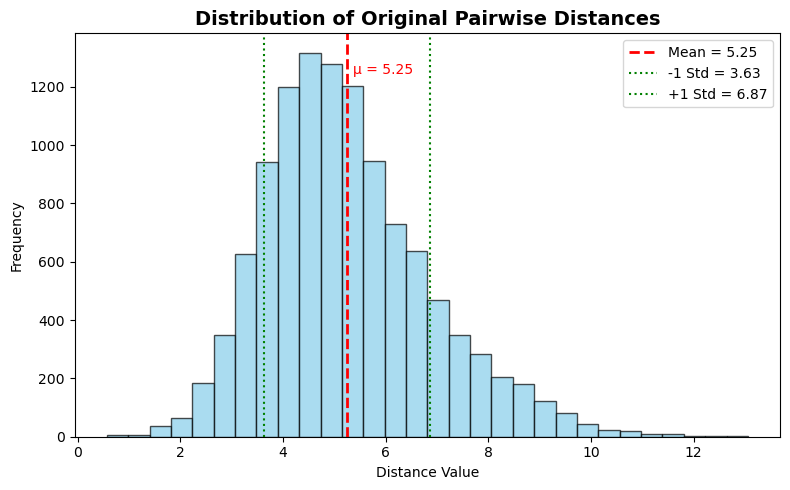

Normalized distances - Mean: -0.0000, Std Dev: 1.0000


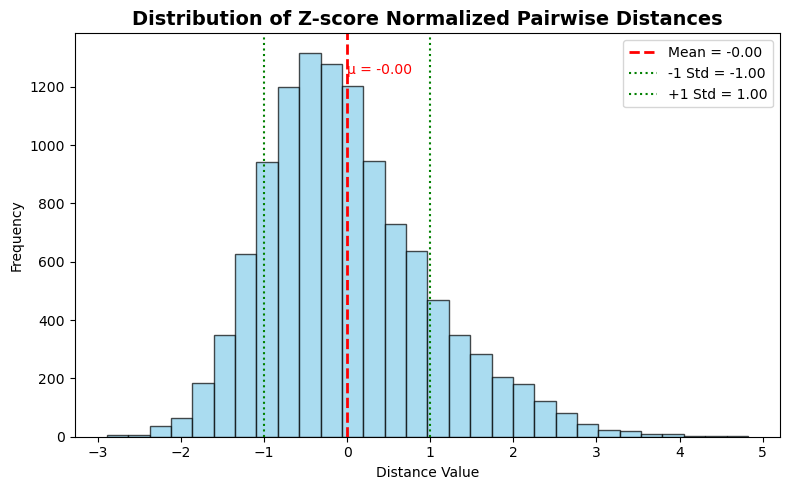

In [80]:
if __name__ == "__main__":
    zscore_cols = [f'{c}_zscore' for c in skill_columns]
    
    # Calculate and plot original distances
    distances = calculate_distances(final_df, zscore_cols)
    condense_distances = condense_distance_matrix(distances)
    mean, std = compute_dist_mean_std(condense_distances)
    print(f"Original distances - Mean: {mean:.4f}, Std Dev: {std:.4f}")
    plot_distance_distribution(condense_distances, mean, std, 'Distribution of Original Pairwise Distances')

    # Normalize and plot z-score distances
    normalized_condensed_distances = normalize_distances(condense_distances)
    mean, std = compute_dist_mean_std(normalized_condensed_distances)
    print(f"Normalized distances - Mean: {mean:.4f}, Std Dev: {std:.4f}")
    plot_distance_distribution(normalized_condensed_distances, mean, std, 'Distribution of Z-score Normalized Pairwise Distances')

    # Convert back to square form
    normalized_distances = squareform_distance_matrix(normalized_condensed_distances)

### 3. Graph Construction Based on Distance Thresholds

In [81]:
def construct_graph(df, distance_matrix, threshold, name):
    """
    Constructs a graph based on a distance threshold.
    
    IN:
    df: pd.DataFrame, dataframe with node information.
    distance_matrix: np.array, 
    threshold: float, the distance threshold for creating edges.
    name: str, the name of the graph.
    
    OUT:
    G: nx.Graph, the constructed graph.
    """
    G = nx.Graph(name=name)
    
    # Add nodes with attributes
    # Your_Code_Here
        
    # Add edges based on the threshold
    # Your_Code_Here
                
    return G

In [82]:
if __name__ == "__main__":
    # The mean of z-score normalized distances is approximately 0, and the standard deviation is 1.
    # Thresholds are defined in terms of standard deviations below the mean.
    thresholds = {
        -3: -3,  # 3 SD below the mean
        -2: -2,  # 2 SD below the mean
        -1: -1   # 1 SD below the mean
    }
    
    graphs = {}
    for sd, thresh_val in thresholds.items():
        graph_name = f"Student_Assessment_Graph_{sd}SD"
        # The z-score normalized distance matrix is used for graph construction.
        graphs[graph_name] = construct_graph(final_df, normalized_distances, thresh_val, graph_name)
        print(f"Graph '{graph_name}' constructed with threshold {thresh_val}.")
        print(f"  - Nodes: {graphs[graph_name].number_of_nodes()}")
        print(f"  - Edges: {graphs[graph_name].number_of_edges()}")

Graph 'Student_Assessment_Graph_-3SD' constructed with threshold -3.
  - Nodes: 0
  - Edges: 0
Graph 'Student_Assessment_Graph_-2SD' constructed with threshold -2.
  - Nodes: 0
  - Edges: 0
Graph 'Student_Assessment_Graph_-1SD' constructed with threshold -1.
  - Nodes: 0
  - Edges: 0


### 4. Graph Analysis

Note: break tie for nodes of the same degree by their `netid` alphabetically in non-decreasing order.

In [83]:
def analyze_graph(G, df):
    """
    Performs analysis for a given graph.
    
    IN:
    G: nx.Graph, the graph to analyze.
    df: pd.DataFrame, dataframe with node attributes.
    
    OUT:
    analysis_results: dict,
        {"num_nodes": int,
         "num_edges": int,
         "avg_degree": float,
         "degrees": list of int,
         "top_10_nodes": list of [str, int] as [netid, degree],
         "num_components": int,
         "comp_sizes": list of ints as [vSize, eSize]
         }
    """
    # Your_Code_Here

    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "avg_degree": avg_degree,
        "degrees": degrees,
        "top_10_nodes": top_10_nodes,
        "num_components": num_components,
        "comp_sizes": comp_sizes
    }

In [84]:
def plot_degree_distribution(G, analysis_results):
    """
    Visualizes the analysis results of a graph.
    
    IN:
    G: nx.Graph, the graph to visualize.
    analysis_results: dict, the analysis results from analyze_graph.
    """

    avg_degree = analysis_results['avg_degree']
    degrees = analysis_results['degrees']
    top_10_nodes = analysis_results['top_10_nodes']


    # Degree distribution
    # Your_Code_Here

In [85]:
def compute_cc_size_frequency(comp_sizes):
    """
    Computes the frequency of connected component sizes.
    
    IN:
    comp_sizes: list of tuples (vSize, eSize) for each connected component.
    
    OUT:
    comp_size_freq: dict {(vSize, eSize): frequency}
    """
    # Your_Code_Here
    return comp_size_freq

In [86]:
def plot_cc_size_distribution(comp_size_freq):
    """
    Plots the connected component size distribution.
    
    IN:
    comp_size_freq: dict {(vSize, eSize): frequency}
    """
    # Your_Code_Here


In [87]:
def plot_graph_layout(G):
    """
    Plots the force-directed layout of the graph.

    IN:
    G: nx.Graph, the graph to visualize.
    """
    # Your_Code_Here

Note: the expected output format for saving the graphs in JSON is as follows:

```json
{
  "nodes": [
    { "id": "node1", "total_score": 1.23},
    { "id": "node2", "total_score": 2.34},
    ...
  ],
  "links": [
    { "source": "node1", "target": "node2" },
    ...
  ]
}
```

In [88]:
def save_graph_to_json(G):
    """
    Saves the graph to a JSON file in node-link format.
    
    IN:
    G: nx.Graph, the graph to save.
    """
    
    # Save graph to JSON format
    graph_data = nx.node_link_data(G, nodes="nodes", edges="links")
    json_filename = f"{G.name}.json"
    with open(json_filename, 'w') as f:
        json.dump(graph_data, f, indent=4)
    print(f"Graph saved to {json_filename}")

In [89]:
if __name__ == "__main__":
    for name, graph in graphs.items():
        print(f"\n--- Analysis for {name} ---")
        analysis_results = analyze_graph(graph, final_df)
        top_10_netids = [netid for netid, _ in analysis_results['top_10_nodes']]
        top_10_info = final_df[final_df['netid'].isin(top_10_netids)][['netid', 'total_score']]
        print(f"\nTop 10% ({len(top_10_info)} students) by degree:")
        print(top_10_info)

        plot_degree_distribution(graph, analysis_results)

        comp_size_freq = compute_cc_size_frequency(analysis_results['comp_sizes'])
        plot_cc_size_distribution(comp_size_freq)


        plot_graph_layout(graph)
        
        save_graph_to_json(graph)


--- Analysis for Student_Assessment_Graph_-3SD ---


NameError: name 'num_nodes' is not defined

After exporting each graph to JSON, the files may be visualized interactively using `2D-vis.html` or `3D-vis.html`.

To encode vertex colors according to the `total_score` attribute, include a `color` property for each node in the JSON representation.

Suggested procedure:
1. Map the `total_score` values to an appropriate color scale (for example, a sequential or diverging colormap).
2. Convert the mapped color values to a hexadecimal RGB string (for example `#66ccff`).
3. Assign the resulting hex string to the node's `color` property, e.g. `node["color"] = "#66ccff"`.

An example of the expected JSON structure is shown below:
```json
{
  "nodes": [
    { "id": "node1", "total_score": 1.23, "color": "#66ccff" },
    { "id": "node2", "total_score": 2.34, "color": "#ff0000" },
    ...
  ],
  "links": [
    { "source": "node1", "target": "node2" },
    ...
  ]
}
```

When such a JSON file is loaded into `2D-vis.html` or `3D-vis.html`, the renderer will apply the specified `color` values to the vertices, producing a visualization in which node colors reflect their `total_score`.